In [1]:
import numpy as np
from cvxopt import matrix, solvers, log, exp
import matplotlib.pyplot as plt

from matplotlib import style
import matplotlib
plt.style.use('ggplot')
matplotlib.rcParams.update({"axes.grid" : False})

from PyomoSolver import PyomoSolver

### set up problem

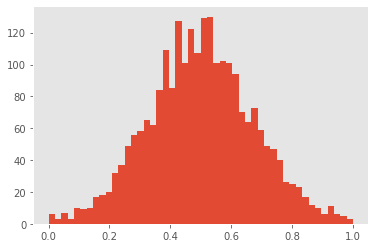

In [2]:
N = 60
M = 40
T = 600

# noise sub-gaussianity parameter
eta = 1
# maximum value of R
max_R = 1
# rank of R
rank = 5

R_temp = np.random.binomial(1, 0.5, size=(N, M))
u, s, vt = np.linalg.svd(R_temp, full_matrices = False)
s[rank:] = 0

R_true = u @ np.diag(s) @ vt
lower = np.quantile(R_true, 0.999)
upper = np.quantile(R_true, 0.001)
R_true = np.clip(R_true, upper, lower)
R_true = max_R * (R_true - lower) / (upper - lower)

plt.hist(R_true.flatten(), bins=np.int32(np.sqrt(N * M)))
plt.show()
# _, s, _ = np.linalg.svd(R_true)
# plt.yscale("log")
# plt.plot(s)
# plt.show()

### set static capacities

In [3]:
# capacities
C = np.ones(M)
# demands
D = np.ones(N)

### ILP Solver

In [4]:
solver = PyomoSolver(N, M, C, D)

In [5]:
def shift_prices(R, x, p):
    p_extended = np.tile(p,(N, 1))
    margin = x * (R - p_extended) + (1 - x) * max_R
    min_margin = np.min(margin)
    return p + np.maximum(min_margin, 0) - 1e-6

In [6]:
def get_offerings_and_prices(R):
    x = solver.solve_system(R)
    p = solver.get_prices()
    p = shift_prices(R, x, p)
    return x, p

In [7]:
def filter_decisions(x, p):
    accepted = np.int32(R_true > p)
    return x * accepted

In [8]:
def get_surplus(x):
    return np.sum(x * R_true)

### get the optimum solution

In [9]:
x_opt, p_opt = get_offerings_and_prices(R_true)
surplus_opt = get_surplus(x_opt)
print(surplus_opt)
print(p_opt)

32.456729408638665
[0.6335117  0.8014599  0.58561721 0.79749949 0.74414664 0.6857345
 0.80405218 0.85156124 0.74864407 0.8304782  0.9074568  0.68753692
 0.69999177 0.76290106 0.7938089  0.76709537 0.69177224 0.82665645
 0.81566729 0.58152617 0.69690374 0.71108329 0.78449852 0.69167323
 0.84117606 0.65541819 0.70920214 0.60731285 0.78095464 0.93851137
 0.54317026 0.95858423 0.62975747 0.75739972 0.79882652 0.71680888
 0.61652044 0.81895342 0.85256169 0.91401255]


### solve while learning

In [10]:
def update_intervals(R_lower, R_upper, p, x_accepted, x_rejected):
    p_extended = np.tile(p,(N, 1))
    R_lower = x_accepted * p_extended + (1 - x_accepted) * R_lower
    R_upper = x_rejected * p_extended + (1 - x_rejected) * R_upper
    return R_lower, R_upper

In [11]:
def get_proxy(R_lower, R_upper, alpha):
    R_proxy = R_lower + alpha * (R_upper - R_lower)
    return R_proxy

In [12]:
# def update_counts(counts, x_offered):
#     new_counts = x_offered + (counts + 1) * (1 - x_offered)
#     return new_counts

In [13]:
alpha_list = [0.5, 0.6, 0.7, 0.8]
rewards = np.zeros((len(alpha_list), T))
acceptance = np.zeros((len(alpha_list), T))

for i, alpha in enumerate(alpha_list):
    R_lower = np.zeros((N, M))
    R_upper = max_R * np.ones((N, M))
    #counts = np.ones((N, M))
    for t in range(T):
        # get a point in each interval
        R_proxy = get_proxy(R_lower, R_upper, alpha)

        x_offered, p = get_offerings_and_prices(R_proxy)
        #counts = update_counts(counts, x_offered)

        x_accepted = filter_decisions(x_offered, p)
        x_rejected = x_offered - x_accepted
        R_lower, R_upper = update_intervals(R_lower, R_upper, p, x_accepted, x_rejected)

        acceptance[i, t] = np.sum(x_accepted) / np.sum(x_offered)
        rewards[i, t] = get_surplus(x_accepted)
        
        if t % 10 == 0:
            print(t, rewards[i, t], acceptance[i, t])
        
    print("done")

0 13.727905430751708 0.525
10 26.826060598150644 1.0
20 26.324615242618126 0.975
30 26.826060598150644 1.0
40 26.826060598150644 1.0
50 26.826060598150644 1.0
60 26.826060598150644 1.0
70 26.826060598150644 1.0
80 26.826060598150644 1.0
90 26.826060598150644 1.0
100 26.826060598150644 1.0
110 26.826060598150644 1.0
120 26.826060598150644 1.0
130 26.826060598150644 1.0
140 26.826060598150644 1.0
150 26.826060598150644 1.0
160 26.826060598150644 1.0
170 26.826060598150644 1.0
180 26.826060598150644 1.0
190 26.826060598150644 1.0
200 26.826060598150644 1.0
210 26.826060598150644 1.0
220 26.826060598150644 1.0
230 26.826060598150644 1.0
240 26.826060598150644 1.0
250 26.826060598150644 1.0
260 26.826060598150644 1.0
270 26.826060598150644 1.0
280 26.826060598150644 1.0
290 26.826060598150644 1.0
300 26.826060598150644 1.0
310 26.826060598150644 1.0
320 26.826060598150644 1.0
330 26.826060598150644 1.0
340 26.826060598150644 1.0
350 26.826060598150644 1.0
360 26.826060598150644 1.0
370 26.8

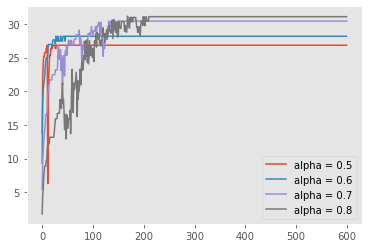

In [14]:
for i, alpha in enumerate(alpha_list):
     plt.plot(np.arange(T), rewards[i], label = "alpha = {}".format(alpha))
plt.legend()
plt.show()

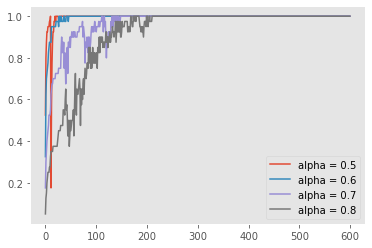

In [15]:
for i, alpha in enumerate(alpha_list):
     plt.plot(np.arange(T), acceptance[i], label = "alpha = {}".format(alpha))
plt.legend()
plt.show()

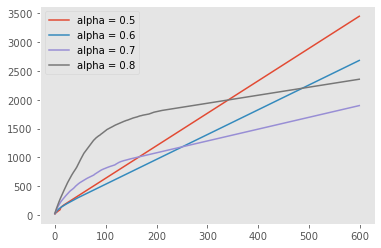

In [18]:
regrets = surplus_opt - rewards

for i, alpha in enumerate(alpha_list):
     plt.plot(np.arange(T), np.cumsum(regrets[i]), label = "alpha = {}".format(alpha))
plt.legend()
plt.show()